# Introduction

Welding is one key aspect in manufacturing for combing metals. Even though it has been practiced for a considerable amount of time, errors still occur - be this from machinery doing the welding or humans. In addition, the welds can also break and be damaged from external sources, thus being defekt. There are many use cases for why detecting the quality of a weld can beneficial. For one, it can help in identifying if a metal contruction is still safe and robust. Second, it can be used during human training. If a computer system would be implemented to grade the students work, being able to identify and distinguish between good, bad and defect welds is elemental. Similarly, if such a recognition model would be used in a factory to ensure product quality and thus customer satisfaction, being able to recognize and distinguish is key. In the future, it might pave the way for a model to learn the exact quality grade of a weld, i.e. 0 being complety defect and 1ß0 being perfect, thereby giving an even more detailled look into welding works/quality. 

As such, a dataset containing welding pictures has been chosen. Some images were caputred in a lab enviroment (see images starting with "Sample") and some from less staged scenes. 
The data is labelled into 3 categories: 0 refers to bad weld, 1 to good weld and 2 to defect. Each image can contain multiple labels. As such we are dealing with multilabel image classification and/or object detection. The latter since we have the bounding boxes. Thus, we are not dealing with a classical (multi-class) image classification task but a more complex mission.

To (hopefully) create a accurate and fast model, we will explore the data, looking for any disrupancies or aspects to care for. Next, We will define a standard pre-processing pipieline (grayscaling, blurring and rescaling). We will then define 2 custom models and one adjusted VGG-16 model (a popular CNN which is still used in modern and critical enviroments (Sunyoto et al., 2022)). After that, we will train and evaluate them, choosing one model for further inspection. Simultanously, i will fine-tune a YOLOv8 model with pre-trained weights. At the end, we will compare these 3 models again and come to a conclusion, critically reflecting on the work and poiting out further directions.
 


Since object detection architectures/models are highly complex, a few (pre-trained) state-of-the-art models are usually maintained and made public, i.e. YOLO. Other models like Faster R-CNN or Single-Shot Detector (SSD) exist. However, their existence does not merely mean they are usuable by everyone in a trivial fashion. These highly complex models require profound computational resources and setup time. Therefore, we will investigate one of these models namely YoloV8 (Version 8). It is a popular version of YOLO and its implementation effort is manageable.

# Exploratory data analysis

In [53]:
import pandas as pd
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import tensorflow as tf
import keras.utils as image
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import time


## Inspecting discrepancies in the images

### Text in the images

Some images have text. This is either the source of the video or an explanation about what can be seen in the image. Sometimes the text is smaller, sometimes bigger. In the following we can see that the left image has text that spans over about a third of the image. On the right image, in bottom-right hand side we can see a small text logo.

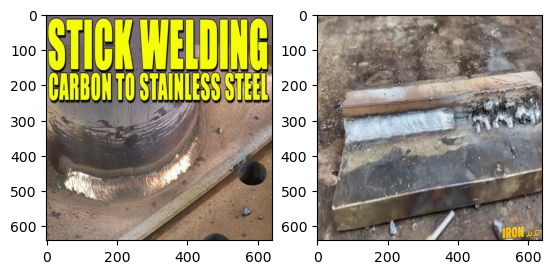

In [55]:
path_text_example1 = "train/images/carbon-steel-good-welds_14_jpeg_jpg.rf.49688b4d08c60bf6a65cc6f03e7d25ff.jpg"
img_text_example1 = Image.open(path_text_example1)

image_datas = []
image_datas.append(img_text_example1)

path_text_example2 = "train/images/bad_weld_vid282_jpeg_jpg.rf.f1ab7871565d470f35111fcf0bcee841.jpg"
img_text_example2 = Image.open(path_text_example2)
image_datas.append(img_text_example2)


f, axarr = plt.subplots(1,2)
axarr[0].imshow(image_datas[0])
axarr[1].imshow(image_datas[1])

### Mixture of pre-processed on non-processed images

There are also plenty of images that seem to have been pre-processed. They are rotated, brightness (or contrast) is adjusted and noise has been added. Sifting through the file name it seems that the pre-processed images have '-' and not 'jpeg' in their name.

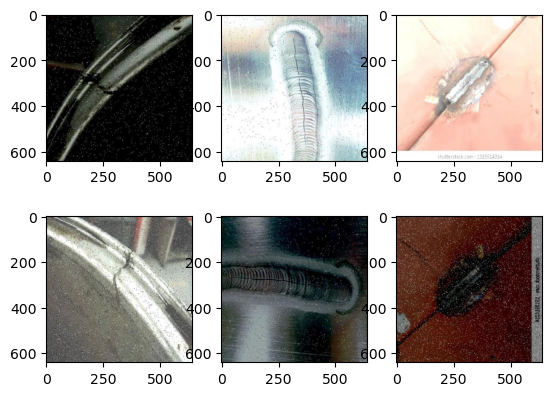

In [56]:
path_pre_list = ["train/images/0e538f39-1d30436c-c23_jpg.rf.9af91763a613bf193d03c39400da2ec6.jpg", "train/images/0e538f39-1d30436c-c23_jpg.rf.05ff78024b481ae4fada24ef439ebd97.jpg","train/images/4d02e003-793c44d4-DWAi7_eXcAAdxuF_jpg.rf.1ed5c14711c779c7eeaba2af500c9167.jpg","train/images/4d02e003-793c44d4-DWAi7_eXcAAdxuF_jpg.rf.2363b9baae3cd601d7c6270f9141ff80.jpg","train/images/53b5de7a-77e2178f-weld-cracking-centerline-longitudinal-crack-260nw-1313514314_jpg.rf.ce6ebf49b78fbe150d2bf182d5b57549.jpg","train/images/53b5de7a-77e2178f-weld-cracking-centerline-longitudinal-crack-260nw-1313514314_jpg.rf.4a55fb16105c903fb111559a7fae1d35.jpg"]
f, axarr = plt.subplots(2,3)
img_pre_list = []

for path in path_pre_list:
    img_pre_list.append(Image.open(path))

axarr[0,0].imshow(img_pre_list[0])
axarr[1,0].imshow(img_pre_list[1])
axarr[0,1].imshow(img_pre_list[2])
axarr[1,1].imshow(img_pre_list[3])
axarr[0,2].imshow(img_pre_list[4])
axarr[1,2].imshow(img_pre_list[5])

### Unsharp images

Usually the images are sharp/focussed on the weld, but sometimes they aren’t.

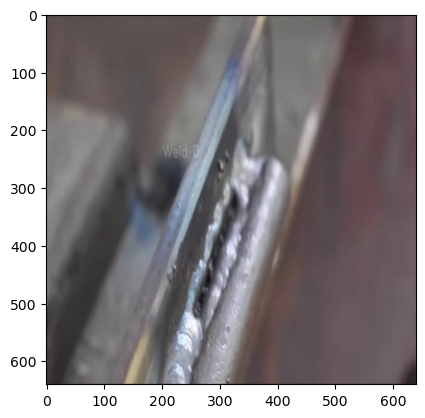

In [57]:
path_unsharp = "train/images/bad_weld_vid560_jpeg_jpg.rf.be4be408da41d602b8c9a7801a7be733.jpg"
img_unsharp = Image.open(path_unsharp)
plt.imshow(img_unsharp)

As we could partly see in the images shown in this notebook, there are plenty of different angles in the dataset that resemble the view of a professional or inspector viewing the weld. Nonetheless, about 60% to seem to resemble lab conditions as is shown in the following.

In [58]:
i = 0
j = 0
for filename in os.listdir("train/images"):
    if "SampleV" not in filename:
        j+=1
        continue
    else: 
        i+=1 
        j +=1

print("Lab images: ",i)
print("POV images: ",j)
print("Portion of lab data in train set:",i/j)

Lab images:  516
POV images:  839
Portion of lab data in train set: 0.6150178784266984


### Completly new 'viewing styles'

Moreover, some views of welds in the validation set are completely new and even for the human eye the class is difficult to discern.

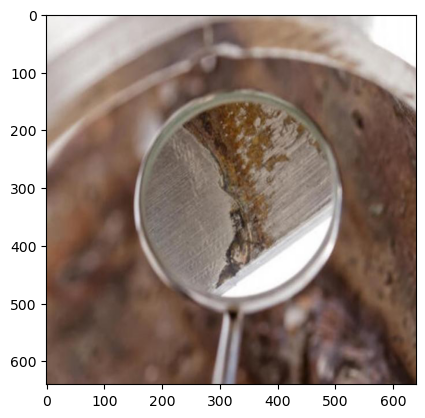

In [59]:
path_view = "valid/images/Screenshot-2022-12-05-231929_jpeg_jpg.rf.0f2a7b6941f6c0b4285f0385cd92f9b3.jpg"
img_view = Image.open(path_view)
plt.imshow(img_view)

### Suspiciously similar images

Some images in the valid set are very similair to each other. In the first code snippet we see two images that are in the same set (validation). The following snippet shows 2 images that resemble an image in the train set.

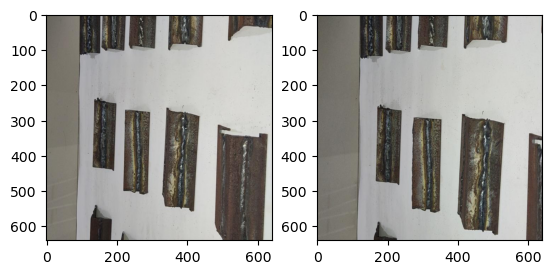

In [60]:
path_pre_list = ['valid/images/SampleV2_2_mp4-107_jpg.rf.6246eabc13b91626965a27f1f15e66da.jpg','valid/images/SampleV2_2_mp4-106_jpg.rf.377879e04f1e7209a3aa340ccfe1084b.jpg']
f, axarr = plt.subplots(1,2)
img_pre_list = []

for path in path_pre_list:
    img_pre_list.append(Image.open(path))

axarr[0].imshow(img_pre_list[0])
axarr[1].imshow(img_pre_list[1])

On a similair note, in the test set there are 2 images that are very similair to each other and an image in the training set (for the latter see first plot of this notebook).

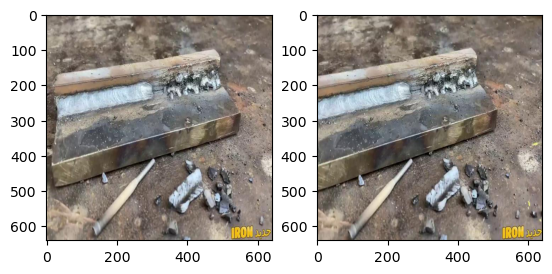

In [61]:
path_dup_example1 = "test/images/bad_weld_vid278_jpeg_jpg.rf.d7b37caf0f75a2942cae27dedf5c4c64.jpg"
img_dup_example1 = Image.open(path_dup_example1)

image_datas = []
image_datas.append(img_dup_example1)

path_dup_example2 = "test/images/bad_weld_vid277_jpeg_jpg.rf.0e6aafa2605c842edfaedaba06ded02c.jpg"
img_dup_example2 = Image.open(path_dup_example2)
image_datas.append(img_dup_example2)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(image_datas[0])
axarr[1].imshow(image_datas[1])

### How to differentiate classes

Good welding, bad welding or welding defects don't seem to show a specefic color. Although good welds seem to shine at a specific angle (see the left image in the following), a lack of a shine in the image isn't conclusive of a weld not being good. In other words, a weld doesn't need to shine in order to be good. Rather, a good weld seems to be related with a smooth and uniform texture (left side of the right image). Bad welds present opposite attributes of good welds. They are very uneven. No specific color differentiates the class. 

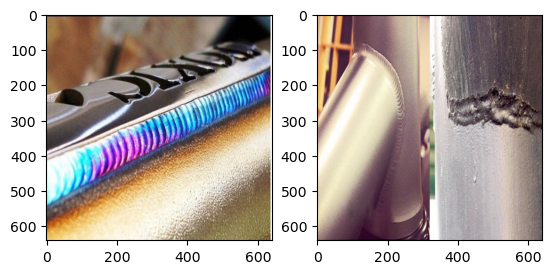

In [62]:
path_good_bad_list = ['train/images/good-tig-welds_8_jpeg_jpg.rf.a1d0d208c286afc59636e3cde9712b92.jpg','train/images/Good-Welding-images_10_jpeg_jpg.rf.01d5e76694c871526ebe4cfc9667ba5a.jpg']
f, axarr = plt.subplots(1,2)
img_good_bad_list = []

for path in path_good_bad_list:
    img_good_bad_list.append(Image.open(path))

axarr[0].imshow(img_good_bad_list[0])
axarr[1].imshow(img_good_bad_list[1])

### Structure of the labels

Each image is labelled. Each row in the corresponding text file indicates the class and the location of the weld (defect). 0 indicates 'Bad Weld', 1 'Good Weld' and 2 'Defect'. The numbers after the class are the bounding boxes.

In [78]:
file = open('train/labels/0e538f39-1d30436c-c23_jpg.rf.3ce38b0e86b3cd83db06acc794de04f0.txt', 'r')
text = file.read()
print(text)

2 0.58515625 0.525 0.41796875 0.178125



### Key takeaways

- The data regarding viewing angles, contrast, brightness and general originality of each picture is very high/diverse

- Text and logos appear in the images
- Similair images exist. Deleting them isn't done due to the already very limited count of data

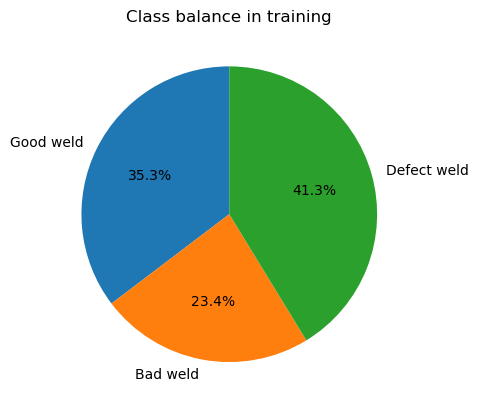

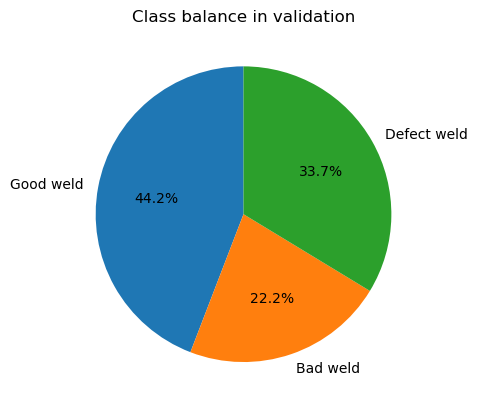

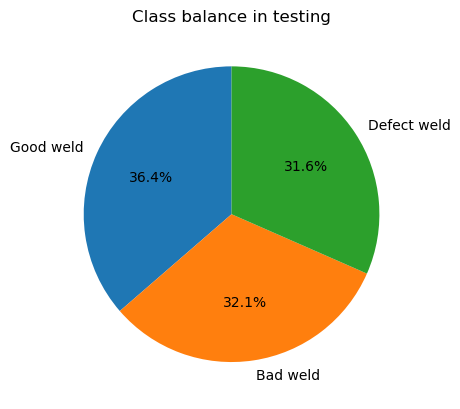

In [80]:
#train set
num_good_train = 0
num_bad_train = 0
num_def_train = 0
for filename in os.listdir("train/labels"):
    path = "train/labels/" + filename
    with open(path, 'r') as file:
        # Read each line in the file
        for line in file:
            line = line[0]
            if line=="0":
                num_bad_train+=1   
            if line == "1":
                num_good_train+=1
            if line == "2":
                num_def_train+=1

train_balance = np.array([num_good_train, num_bad_train, num_def_train])
mylabels = ["Good weld", "Bad weld", "Defect weld"]

plt.pie(train_balance, labels = mylabels, startangle = 90, autopct = '%1.1f%%')
plt.title("Class balance in training")
plt.show()

# validation set
num_good_valid = 0
num_bad_valid = 0
num_def_valid = 0
for filename in os.listdir("valid/labels"):
    path = "valid/labels/" + filename
    with open(path, 'r') as file:
        # Read each line in the file
        for line in file:
            line = line[0]
            if line=="0":
                num_bad_valid+=1   
            if line == "1":
                num_good_valid+=1
            if line == "2":
                num_def_valid+=1

valid_balance = np.array([num_good_valid, num_bad_valid, num_def_valid])

plt.pie(valid_balance, labels = mylabels, startangle = 90, autopct = '%1.1f%%')
plt.title("Class balance in validation")
plt.show()

# testing set
num_good_test = 0
num_bad_test = 0
num_def_test = 0
for filename in os.listdir("test/labels"):
    path = "test/labels/" + filename
    with open(path, 'r') as file:
        # Read each line in the file
        for line in file:
            line = line[0]
            if line=="0":
                num_bad_test+=1   
            if line == "1":
                num_good_test+=1
            if line == "2":
                num_def_test+=1

test_balance = np.array([num_good_test, num_bad_test, num_def_test])

plt.pie(test_balance, labels = mylabels, startangle = 90, autopct = '%1.1f%%')
plt.title("Class balance in testing")
plt.show()



# Define some necessary functions

### For data formatting

In [68]:
# Assisted by ChatGPT
from PIL import Image
import numpy as np

def rotate_image(image_array, degree):
    """
    Rotate images in the image_array by the specified degree (90, 180, 270).
    
    Parameters:
    - image_array: A list or array of images to be rotated (as NumPy arrays with shape (H, W, 3)).
    - degree: The degree of rotation (90, 180, or 270).
    
    Returns:
    - rotated_images: A list of rotated images in the same format as the input (NumPy arrays).
    """
    rotated_images = []
    
    for img in image_array:
        # Convert image to PIL format
        np_img_uint8 = (img * 255).astype(np.uint8)  # Assuming img is in [0, 1] range
        original_image = Image.fromarray(np_img_uint8)
        size = original_image.size  # (width, height)

        # Rotate the image
        if degree == 90:
            rotated_image = original_image.rotate(90, expand=True)
        elif degree == 180:
            rotated_image = original_image.rotate(180, expand=True)
        elif degree == 270:
            rotated_image = original_image.rotate(270, expand=True)
        else:
            raise ValueError("Degree must be 90, 180, or 270")

        # Convert rotated image back to array
        rotated_img_array = np.array(rotated_image) / 255.0  # Normalize back to [0, 1]
        rotated_images.append(rotated_img_array)
    
    return rotated_images


In [69]:
from tqdm import tqdm
# Assisted by chatgpt
# Loads images from a directory
def load_images(split_path, size, color_mode, blur_size):
    y = []
    x = []
    bounding_boxes = []
    for fname in tqdm(os.listdir((split_path+"images/"))):
        img_path = os.path.join(split_path+"images/",fname)

        # Load and resize image
        img = image.load_img(img_path, color_mode=color_mode) # , target_size=IMAGE_SIZE, color_mode=COLOR_MODE)

        # Convert to array
        img_array = image.img_to_array(img)  # shape: (H, W, C)

        if size != 640:
            blur = cv.blur(img_array,(blur_size,blur_size))
            img_array = cv.resize(blur, (size, size))

        # Normalize to [0,1]
        img_array /= 255.0

        x.append(img_array)

        if "test" in split_path:
            path_label = split_path + "labels/" + img_path[12:-3] + "txt"
        
        else:
            path_label = split_path + "labels/" + img_path[13:-3] + "txt"
        with open(path_label, 'r') as file:
            # Read each line in the file
            classes = []
            bounding_box_string = []
            for line in file:
                classes.append(line[0])
                bounding_box_string.append(line[2:-1])
        
            y.append(classes)
            bounding_boxes.append(bounding_box_string)

    return [np.array(x, dtype=np.float32), y, bounding_boxes]

In [70]:
# Translate bounding box to coordiantes
def bbox_to_coord(bbox):
    array_image = []
    for img_arr in bbox:
        array_class = []
        for class_instance in img_arr:
            
            bbox = class_instance.strip().split(' ')  # skip class id, get bbox only
            
            x_center, y_center, width, height = map(float, bbox)

            # Denormalize
            x_center *= 640
            y_center *= 640
            width *= 640
            height *= 640

            # Convert to top-left and bottom-right
            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x_center + width / 2
            y2 = y_center + height / 2

            array_class.append([x1,y1,x2,y2])

        array_image.append(array_class)

    return array_image
        

In [71]:
# Formats the labels
def label_string_to_unique(label_array):
    binary_label_train_y = []
    for array in label_array:
        good = 0
        bad = 0
        defect = 0
        for element in array:
            if element == "0":
                bad = 1
            elif element == "1":
                good = 1
            else:
                defect = 1
        binary_label_train_y.append([bad,good,defect])

    return np.array(binary_label_train_y)

### To training models

In [72]:
def cnn_x_model(size, num):
    return tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu" , input_shape = ((size, size, num))),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation ="relu"),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(128,activation ="relu"),
    tf.keras.layers.Dense(3,activation = "sigmoid")
])

In [73]:
def cnn_x_dropout_model(size, num):
    return tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu" , input_shape = ((size, size, num))),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation ="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128,activation ="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3,activation = "sigmoid")
])

In [74]:
def vgg_x_model(size, num):
    # Using information found in https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,(3,3),activation = "relu" , input_shape = ((size, size, num))) ,
        tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),
        tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(256,(3,3),activation = "relu"), 
        tf.keras.layers.Conv2D(256,(3,3),activation = "relu"),
        tf.keras.layers.Conv2D(256,(3,3),activation = "relu"),   
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(512,(3,3),activation = "relu"),
        tf.keras.layers.Conv2D(512,(3,3),activation = "relu"), 
        tf.keras.layers.Conv2D(512,(3,3),activation = "relu"),  
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(512,(3,3),activation = "relu"),
        tf.keras.layers.Conv2D(512,(3,3),activation = "relu"), 
        tf.keras.layers.Conv2D(512,(3,3),activation = "relu"),  
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(4096,activation="relu"),      
        tf.keras.layers.Dense(4096,activation ="relu"),
        tf.keras.layers.Dense(3,activation = "sigmoid")  
    ])

# Modelling

We will be training a simple CNN, one with dropouts layers and one dense net (custom VGG-16). 
Each model will be trained with an input of 256x256 in grayscale format, 400x400 in grayscale and once without any pre-processing (so 640x640 rgb). The baseline will be around 30%, the distribution of the classes. 

Trying out different combinations of the input layer will give us useful information regarding in which direction we should go to further improve the model, i.e. usefulness of high resolution and rgb spectrum. However, in contrast to traditional mashine learning, hyperparameter tuning is more complex and expensive. Thus, this will have to suffice as a rough tuning process.

Due to limited system memory we will train the model after its compilation. Once every model has finished, we will combine the results in a table and compare them. Also, each model is saved under "saved_models/". 

### Setting the seed

In [75]:
from numpy.random import seed
import keras
from keras import layers
from keras import initializers

seed(1)
tf.random.set_seed(1)
keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

### Setting up the data

In [76]:
# Setting up the training data
train_x_gray_256, train_y, bbox_train = load_images("train/", 256, 'grayscale', 2)
train_x_gray_400, train_y, bbox_train = load_images("train/", 400, 'grayscale', 2)
train_x, train_y, bbox_train = load_images("train/", 640, 'rgb', 2)
binary_label_train_y = label_string_to_unique(train_y)

# Setting up the validation data
valid_x_gray_256, valid_y, bbox_valid = load_images("valid/", 256, 'grayscale', 2)
valid_x_gray_400, valid_y, bbox_valid = load_images("valid/", 400, 'grayscale', 2)
valid_x, valid_y, bbox_valid = load_images("valid/", 640, 'rgb', 2)
binary_label_valid_y = label_string_to_unique(valid_y)

# Setting up the testing data
test_x_gray_256, test_y, bbox_test = load_images("test/", 256, 'grayscale', 2)
test_x_gray_400, test_y, bbox_test = load_images("test/", 400, 'grayscale', 2)
test_x, test_y, bbox_test = load_images("test/", 640, 'rgb', 2)
binary_label_test_y = label_string_to_unique(test_y)

100%|██████████| 74/74 [00:00<00:00, 264.30it/s]


### 256x256 in grayscale format

#### Simple CNN

In [ ]:
# Defining the simple custom CNN
cnn_256_g_model = cnn_x_model(256, 1)

/opt/anaconda3/envs/manufacturing/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
cnn_256_g_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
cnn_256_g_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,240,195 (225.98 MB)

 Trainable params: 59,240,195 (225.98 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_cnn_256_g_model = cnn_256_g_model.fit(
    train_x_gray_256, binary_label_train_y,
    validation_data=(valid_x_gray_256, binary_label_valid_y),
    batch_size=32,
    epochs=5, # TODO: More epochs
    callbacks=[callback],
    verbose=1
)

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 714ms/step - accuracy: 0.2054 - loss: 0.7440 - val_accuracy: 0.2386 - val_loss: 0.6764
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 747ms/step - accuracy: 0.2388 - loss: 0.6090 - val_accuracy: 0.2159 - val_loss: 0.8115
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 733ms/step - accuracy: 0.3511 - loss: 0.5004 - val_accuracy: 0.3409 - val_loss: 0.6420
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 737ms/step - accuracy: 0.4988 - loss: 0.3203 - val_accuracy: 0.4091 - val_loss: 0.9631
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 760ms/step - accuracy: 0.6117 - loss: 0.1461 - val_accuracy: 0.3580 - val_loss: 1.0694


In [ ]:
cnn_256_g_model.save("saved_models/cnn_256_g_model.h5")

#### Dropout CNN

In [76]:
# Refining the custom CNN with dropout
cnn_256_g_dropout_model = cnn_x_dropout_model(256, 1)

/opt/anaconda3/envs/manufacturing/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
cnn_256_g_dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [78]:
cnn_256_g_dropout_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,240,195 (225.98 MB)

 Trainable params: 59,240,195 (225.98 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history_cnn_256_g_model = cnn_256_g_dropout_model.fit(
    train_x_gray_256, binary_label_train_y,
    validation_data=(valid_x_gray_256, binary_label_valid_y),
    batch_size=32,
    epochs=5, # TODO: More epochs
    callbacks=[callback],
    verbose=1
)

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 721ms/step - accuracy: 0.2583 - loss: 0.9040 - val_accuracy: 0.0739 - val_loss: 0.6865
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 805ms/step - accuracy: 0.1539 - loss: 0.6687 - val_accuracy: 0.0739 - val_loss: 0.6904
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 803ms/step - accuracy: 0.1591 - loss: 0.6516 - val_accuracy: 0.0739 - val_loss: 0.6881


In [55]:
cnn_256_g_dropout_model.save("saved_models/cnn_256_g_dropout_model.h5")

#### VGG-16

In [79]:
# Defining the custom VGG-16
vgg_256_g_model = vgg_x_model(256, 1)

In [80]:
# Compiling the model
vgg_256_g_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [81]:
vgg_256_g_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 252, 252, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 122, 122, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 59, 59, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 57, 57, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 55, 55, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 23, 23, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 21, 21, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,899,843 (152.21 MB)

 Trainable params: 39,899,843 (152.21 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history_cnn_256_g_model = vgg_256_g_model.fit(
    train_x_gray_256, binary_label_train_y,
    validation_data=(valid_x_gray_256, binary_label_valid_y),
    batch_size=32,
    epochs=5, # TODO: More epochs
    callbacks=[callback],
    verbose=1
)

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 252s 9s/step - accuracy: 0.2758 - loss: 2.2849 - val_accuracy: 0.0739 - val_loss: 0.6927
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 274s 10s/step - accuracy: 0.1463 - loss: 0.6587 - val_accuracy: 0.0739 - val_loss: 0.7097
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 768s 29s/step - accuracy: 0.1488 - loss: 0.6529 - val_accuracy: 0.0739 - val_loss: 0.7023
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 921s 35s/step - accuracy: 0.1345 - loss: 0.6616 - val_accuracy: 0.0739 - val_loss: 0.7120


In [56]:
vgg_256_g_model.save("saved_models/vgg_256_g_model.h5")

### 400x400 in grayscale format

#### Simple CNN

In [82]:
# Defining the simple custom CNN
cnn_400_g_model = cnn_x_model(400, 1)


/opt/anaconda3/envs/manufacturing/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [83]:
cnn_400_g_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [84]:
cnn_400_g_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 398, 398, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 197, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 96, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 294912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │   150,995,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,252,739 (576.98 MB)

 Trainable params: 151,252,739 (576.98 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history_cnn_400_g_model = cnn_400_g_model.fit(
    train_x_gray_400, binary_label_train_y,
    validation_data=(valid_x_gray_400, binary_label_valid_y),
    batch_size=32,
    epochs=5, # TODO: More epochs
    callbacks=[callback],
    verbose=1
)

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.2018 - loss: 1.2665 - val_accuracy: 0.2670 - val_loss: 0.6585
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.2750 - loss: 0.5977 - val_accuracy: 0.1591 - val_loss: 0.7511
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.3141 - loss: 0.4681 - val_accuracy: 0.3636 - val_loss: 0.8000
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5571 - loss: 0.3254 - val_accuracy: 0.3125 - val_loss: 0.8873


In [36]:
cnn_400_g_model.save("saved_models/cnn_400_g_model.h5")

#### Dropout CNN 

In [85]:
# Refining the custom CNN with dropout
cnn_400_g_dropout_model = cnn_x_dropout_model(400,1)

In [86]:
cnn_400_g_dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [87]:
cnn_400_g_dropout_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 398, 398, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 197, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 96, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 294912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │   150,995,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,252,739 (576.98 MB)

 Trainable params: 151,252,739 (576.98 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history_cnn_400_g_model = cnn_400_g_dropout_model.fit(
    train_x_gray_400, binary_label_train_y,
    validation_data=(valid_x_gray_400, binary_label_valid_y),
    batch_size=32,
    epochs=5, # TODO: More epochs
    callbacks=[callback],
    verbose=1
)

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.2288 - loss: 1.8430 - val_accuracy: 0.0739 - val_loss: 0.6924
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.1653 - loss: 0.6583 - val_accuracy: 0.0739 - val_loss: 0.6908
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.1827 - loss: 0.6601 - val_accuracy: 0.0795 - val_loss: 0.6901


In [58]:
cnn_400_g_dropout_model.save("saved_models/cnn_400_g_dropout_model.h5")

#### VGG-16

In [88]:
# Defining the custom VGG-16 (256x256 instead of 224x224)
# Using information found in https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918
vgg_400_g_model = vgg_x_model(400,1)

In [89]:
vgg_400_g_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
vgg_400_g_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 398, 398, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 396, 396, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 198, 198, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 196, 196, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 194, 194, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 97, 97, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 95, 95, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 93, 93, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 91, 91, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 45, 45, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 43, 43, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 41, 41, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 39, 39, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 19, 19, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 17, 17, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 13, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4096)           │    75,501,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,008,707 (408.21 MB)

 Trainable params: 107,008,707 (408.21 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
history_cnn_400_g_model = vgg_400_g_model.fit(
    train_x_gray_400, binary_label_train_y,
    validation_data=(valid_x_gray_400, binary_label_valid_y),
    batch_size=16,
    epochs=5, # TODO: More epochs
    callbacks=[callback],
    verbose=1
)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 866s 16s/step - accuracy: 0.1602 - loss: 0.6775 - val_accuracy: 0.0739 - val_loss: 0.7137
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 854s 16s/step - accuracy: 0.1446 - loss: 0.6608 - val_accuracy: 0.0739 - val_loss: 0.7066
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 962s 18s/step - accuracy: 0.1488 - loss: 0.6488 - val_accuracy: 0.0739 - val_loss: 0.6998


In [59]:
vgg_400_g_model.save("saved_models/vgg_400_g_model.h5")

## No pre-processing

### Simple CNN

In [91]:
# Defining the simple custom CNN
cnn_npp_model = cnn_x_model(640, 3)

/opt/anaconda3/envs/manufacturing/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [92]:
cnn_npp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [93]:
cnn_npp_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 638, 638, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 319, 319, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 317, 317, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 158, 158, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 156, 156, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 78, 78, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 778752)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │   398,721,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 398,979,395 (1.49 GB)

 Trainable params: 398,979,395 (1.49 GB)

 Non-trainable params: 0 (0.00 B)

##### Due to computational resources the input data of the following models had be halved, even though this restrics the results

In [ ]:
history_cnn_npp_model = cnn_npp_model.fit(
    train_x[0:400], binary_label_train_y[0:400],
    validation_data=(valid_x, binary_label_valid_y),
    batch_size=32,
    epochs=4, # TODO: More epochs
    callbacks=[callback],
    verbose=1
)

In [ ]:
cnn_npp_model.save("saved_models/cnn_npp_model.h5")

### Dropout CNN

In [94]:
# Defining the custom CNN with dropout
cnn_npp_dropout_model = cnn_x_dropout_model(640, 3)

In [95]:
cnn_npp_dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [96]:
cnn_npp_dropout_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 638, 638, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 319, 319, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 319, 319, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 317, 317, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 158, 158, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 158, 158, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 156, 156, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 78, 78, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 78, 78, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 778752)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │   398,721,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 398,979,395 (1.49 GB)

 Trainable params: 398,979,395 (1.49 GB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history_cnn_npp_dropout_model = cnn_npp_dropout_model.fit(
    train_x[0:400], binary_label_train_y[0:400],
    validation_data=(valid_x, binary_label_valid_y),
    batch_size=32,
    epochs=4, # TODO: More epochs
    callbacks=[callback],
    verbose=1
)

Epoch 1/4
13/13 ━━━━━━━━━━━━━━━━━━━━ 134s 9s/step - accuracy: 0.2109 - loss: 5.1055 - val_accuracy: 0.4830 - val_loss: 0.6914
Epoch 2/4
13/13 ━━━━━━━━━━━━━━━━━━━━ 147s 11s/step - accuracy: 0.2042 - loss: 0.6844 - val_accuracy: 0.4318 - val_loss: 0.6902
Epoch 3/4
13/13 ━━━━━━━━━━━━━━━━━━━━ 1407s 116s/step - accuracy: 0.2106 - loss: 0.6609 - val_accuracy: 0.2955 - val_loss: 0.6889


In [63]:
cnn_npp_dropout_model.save("saved_models/cnn_npp_dropout_model.h5")

### VGG-16

Sadly this model continously crashed even with fewer input data. 

In [64]:
# Defining the custom VGG-16
vgg_npp_model = vgg_x_model(640, 3)

In [ ]:
vgg_npp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

: 

In [ ]:
history_vgg_npp_model = vgg_npp_model.fit(
    train_x[0:400], binary_label_train_y[0:400],
    validation_data=(valid_x, binary_label_valid_y),
    batch_size=32,
    epochs=4, # TODO: More epochs
    callbacks=[callback],
    verbose=1
)

Epoch 1/4


In [ ]:
vgg_npp_model.save("saved_models/vgg_npp_model.h5")

# Evaluation of models

## Calculating metrics

Lets quickly evaluate all models and display them in a table for an adequate comparison

In [25]:
models = ["cnn_256_g_model", "cnn_256_g_dropout_model", "vgg_256_g_model", "cnn_400_g_model", "cnn_400_g_dropout_model", "vgg_400_g_model", "cnn_npp_model", "cnn_npp_dropout_model"]
accuracy = []
loss = []
inference_time = []
for model_name in models[0:3]:
    model = tf.keras.models.load_model(f'saved_models/{model_name}.h5')
    start_time=time.time()
    evaluation = model.evaluate(test_x_gray_256, binary_label_test_y, batch_size=32)
    loss.append(evaluation[0])
    accuracy.append(evaluation[1])
    end_time=time.time()
    inference_time.append((end_time - start_time))


for model_name in models[3:6]:
    model = tf.keras.models.load_model(f'saved_models/{model_name}.h5')
    start_time=time.time()
    evaluation = model.evaluate(test_x_gray_400, binary_label_test_y, batch_size=32)
    loss.append(evaluation[0])
    accuracy.append(evaluation[1])
    end_time=time.time()
    inference_time.append((end_time - start_time))

for model_name in models[6:]:
    model = tf.keras.models.load_model(f'saved_models/{model_name}.h5')
    start_time=time.time()
    evaluation = model.evaluate(test_x, binary_label_test_y, batch_size=32)
    loss.append(evaluation[0])
    accuracy.append(evaluation[1])
    end_time=time.time()
    inference_time.append((end_time - start_time))





3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.3049 - loss: 0.5927


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.0913 - loss: 0.6958


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.0913 - loss: 0.7121


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.2253 - loss: 0.6701


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.0913 - loss: 0.6988


3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.0913 - loss: 0.7353


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 787ms/step - accuracy: 0.2438 - loss: 0.6550


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 830ms/step - accuracy: 0.5039 - loss: 0.6918


In [26]:
df1 = pd.DataFrame(accuracy, index=models, columns=['Accuracy'])
df2 = pd.DataFrame(loss, index=models, columns=['Loss'])
df3 = pd.DataFrame(inference_time, index=models, columns=['Inference Time'])
df = df1.join(df2)
df = df.join(df3)

# Adding num of params manually
num_params = [177, 59, 40, 151, 151, 107, 400, 400]
# Training time was read from the output of model.fit(). Values are in seconds. 
# They might be different to the cell outputs since some external behaviors 
# like laptop going to sleep so calculations slowed down the processing
train_time = [0.730, 0.760, 10, 2, 2.7, 17, 8, 10]
df4 = pd.DataFrame(num_params, index=models, columns=['Number of Paramters in Mil.'])
df5 = pd.DataFrame(train_time, index=models, columns=['Training time in s'])
df6 = df4.join(df5)
df = df.join(df6)


,Accuracy,Loss,Inference Time,Number of Paramters in Mil.,Training time in s
cnn_256_g_model,0.297297,0.596707,0.529902,177,0.73
cnn_256_g_dropout_model,0.081081,0.696216,0.504292,59,0.76
vgg_256_g_model,0.081081,0.710756,5.612515,40,10.00
cnn_400_g_model,0.216216,0.670438,1.054990,151,2.00
cnn_400_g_dropout_model,0.081081,0.700292,1.062336,151,2.70
vgg_400_g_model,0.081081,0.734826,16.071778,107,17.00
cnn_npp_model,0.229730,0.662797,4.201703,400,8.00
cnn_npp_dropout_model,0.500000,0.691743,3.390401,400,10.00


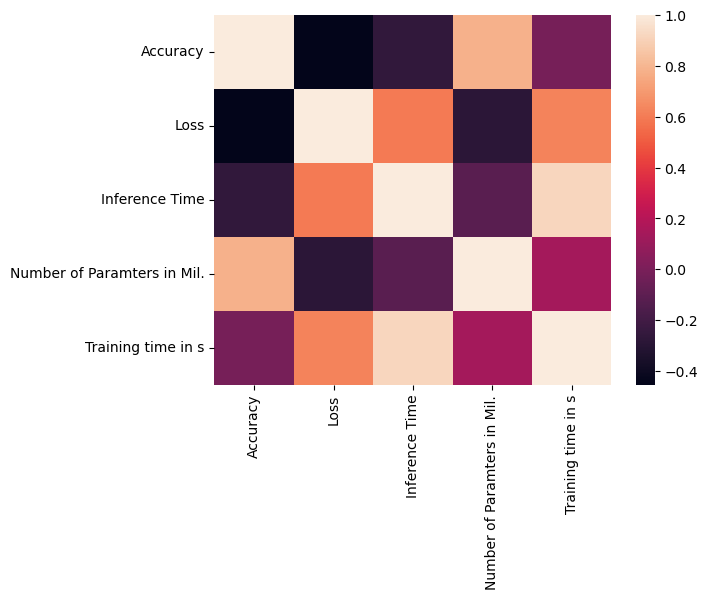

In [27]:
import seaborn as sns

# calculate the correlation matrix on the numeric columns
corr = df.select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr)
df

## Observations, Interpretation and Take-aways

The above table shows the accuracies, loss values and inference time predicting on test data. The heatmap visualizes how they are correlated
In the following the key takeaways are noted.

-  VGG takes signifacantly (12x to 15x) longer than the other CNNs even though it has less parameters. Interestingly, the heatmap also shows that the number of parameters isn't linked to the inference time. So even though more weights have to be considered, the model runs faster. This may be due to the fact that

- Interestingly, even though the model "thinks" longer, accuracy and loss are posivitely and negatively correlated, respectively. Thus, having more parameters aids our predictions.
- Even more parameters didn't lead to increase in training time. Its important to note that the data shows that the training time of the 2 largest (parameter number wise) went up. However, this is most likely explainable to limited computational resources like RAM. So, we would argue that the paramters don't directly impact training or inference time. However, the number of parameters can lead to computational complications, as described and most likely also the case for VGG-16 on 640x640x3 data (see last subchapter above). So the paramters shouldn't mindlessly be increased in hopes of a better model since this might damage other important metrics - or even its trainability
- Increasing the resolution for the simple CNN negatively impacted both metrics. For the dropout and VGG the accuracy stayed exactly the same. The loss, however, increased slightly. This hints towards the fact that the model is overfitting on the training data.
- The dropout layer of the CNN had a negative impact on accuracy and loss. However, once it had many input data, i.e. 640x640x3, the dropout layer seemed to be useful. This could be due to the fact that in smaller sizes the CNN is forced to learn more important features. Thus, "deactivating" some nodes could punish the model. When we have many input data, not all is relevant. Leaving some nodes out might help the model in overfitting while utilizes a lot of the information held in the image.
- Regarding accuracy and loss, the simple CNN trained on grayscaled 256x256 data and the dropout CNN on the "raw" data performed the best. However, the latter needs significant amount more time during training and is up 6x slower during inference. As such, we will try and extend the former model by augmenting the images further.
- Finally, its important to note that we set the distrubtion of the class as the baseline. Only the the last model was able to beat it. This is most likely due to the complexity of the data, i.e. the high variation and low count. Thus, effectively learning is made very difficult.

# YOLO

In [50]:
from ultralytics import YOLO
# You may also need to install pytorch, torchvision since ultralytics needs this

model = YOLO('yolov8n.pt')

Since I rearranged the notebook the whole output wasn't saved. Due to its long computation time I wasn't able to fully replicate it. However, below is a sample. The orignal output can be seen in "full_yolo_output.txt". Alternatively, the whole training parameters, weights and results etc. are found in "runs/detect/train14".

In [ ]:
model.train(data='data.yaml', epochs=30, imgsz=640, batch=16, device="mps")

# Further data augmentation/processing

Let us further augment our images. We will adjust the contrast and flip the images. Each augmentation will be saved as a new image. By enhancing the number of images in our training data we can hopefully gain higher accuracies while maintaining low loss values. We will apply this on the "non-preprocessed data" because the "processed" data already has been augmentated in similair ways (see EDA).

But first, lets define some functions again.

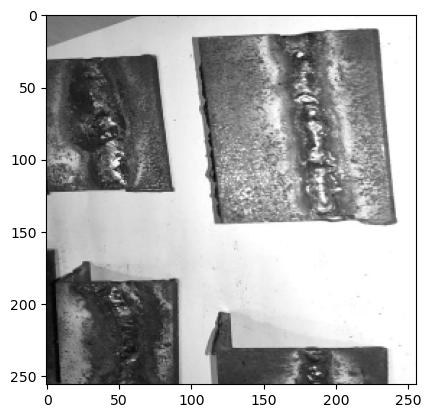

In [20]:
new_train_img = np.array_split(train_x_gray_256, 6)
# Example usage:
rotated_images = rotate_image(new_train_img[0], 90)
plt.imshow(rotated_images[1], cmap="gray")

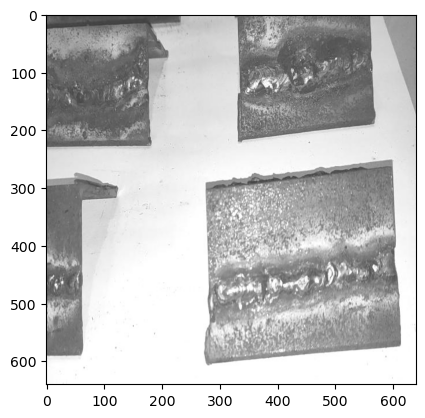

In [13]:
plt.imshow(train_x[1])

In [14]:
new_train_img = np.array_split(train_x_gray_256, 6)

train_img0 = rotate_image(new_train_img[0], 90)
train_img1 = rotate_image(new_train_img[1], 180)
train_img2 = rotate_image(new_train_img[2], 270)
train_img3 = new_train_img[3]
train_img4 = rotate_image(new_train_img[4], 90)
train_img5 = rotate_image(new_train_img[5], 180)
train_img5

[array([[0.90980392, 0.70588235, 0.5372549 , ..., 0.96078431, 0.95294118,
         0.93333333],
        [0.99215686, 0.98039216, 0.91764706, ..., 0.95294118, 0.94509804,
         0.93333333],
        [0.99215686, 0.99607843, 0.94509804, ..., 0.94901961, 0.9372549 ,
         0.93333333],
        ...,
        [0.54117647, 0.54117647, 0.54117647, ..., 0.52941176, 0.54509804,
         0.55686275],
        [0.54117647, 0.54117647, 0.54117647, ..., 0.55294118, 0.52156863,
         0.4745098 ],
        [0.54117647, 0.54117647, 0.54117647, ..., 0.55686275, 0.51372549,
         0.4745098 ]]),
 array([[0.5254902 , 0.35686275, 0.49411765, ..., 0.10196078, 0.10980392,
         0.15294118],
        [0.51764706, 0.53333333, 0.49803922, ..., 0.07058824, 0.11372549,
         0.11764706],
        [0.49803922, 0.50196078, 0.50588235, ..., 0.08627451, 0.08235294,
         0.14901961],
        ...,
        [0.49803922, 0.38823529, 0.49803922, ..., 0.40392157, 0.24313725,
         0.25490196],
        [0.1

In [15]:
# Concatenate all images into a single array
all_train_images = np.concatenate([train_img0, train_img1, train_img2, train_img3, train_img4, train_img5], axis=0)

all_train_images

array([[[0.24705882, 0.21568627, 0.21568627, ..., 0.39215686,
         0.34509804, 0.35294118],
        [0.24313725, 0.19215686, 0.21568627, ..., 0.34117647,
         0.32941176, 0.31764706],
        [0.22352941, 0.20392157, 0.22352941, ..., 0.32156863,
         0.31764706, 0.30588235],
        ...,
        [0.08235294, 0.08235294, 0.08235294, ..., 0.13333333,
         0.1372549 , 0.14509804],
        [0.08627451, 0.08627451, 0.08627451, ..., 0.11764706,
         0.1254902 , 0.13333333],
        [0.09019608, 0.09019608, 0.09019608, ..., 0.11764706,
         0.1254902 , 0.13333333]],

       [[0.58039216, 0.57647059, 0.57254902, ..., 1.        ,
         1.        , 1.        ],
        [0.58039216, 0.58039216, 0.58039216, ..., 1.        ,
         1.        , 1.        ],
        [0.58039216, 0.58039216, 0.58431373, ..., 1.        ,
         1.        , 1.        ],
        ...,
        [0.35294118, 0.38431373, 0.40392157, ..., 0.98823529,
         0.98823529, 0.98431373],
        [0.3

In [21]:
cnn_256_g_rotated_model = cnn_x_model(256, 1)

cnn_256_g_rotated_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/anaconda3/envs/manufacturing/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
history_cnn_256_g_rotated_model = cnn_256_g_rotated_model.fit(
    all_train_images, binary_label_train_y,
    validation_data=(valid_x_gray_256, binary_label_valid_y),
    batch_size=32,
    epochs=10, # TODO: More epochs
    callbacks=[callback],
    verbose=1
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 724ms/step - accuracy: 0.3802 - loss: 0.4832 - val_accuracy: 0.3352 - val_loss: 0.8786
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 707ms/step - accuracy: 0.5065 - loss: 0.3585 - val_accuracy: 0.3864 - val_loss: 0.9062
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 704ms/step - accuracy: 0.6077 - loss: 0.2360 - val_accuracy: 0.3352 - val_loss: 1.2530


In [28]:
cnn_256_g_rotated_model.save("saved_models/cnn_256_g_rotated_model.h5")

In [37]:
start_time=time.time()
evaluation = cnn_256_g_rotated_model.evaluate(test_x_gray_256, binary_label_test_y, batch_size=32)
loss_cmp = evaluation[0]
acc_cmp = evaluation[1]
end_time=time.time()
if_time_cmp = (end_time - start_time)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3369 - loss: 0.7430


## Comparing the simple CNNs after different augmentation techniques

In [49]:
df1_cmp = pd.DataFrame(acc_cmp, index=["cnn_256_g_rotated_model"], columns=['Accuracy'])
df2_cmp = pd.DataFrame(loss_cmp, index=["cnn_256_g_rotated_model"], columns=['Loss'])
df3_cmp = pd.DataFrame(if_time_cmp, index=["cnn_256_g_rotated_model"], columns=['Inference Time'])
df_compar = df1_cmp.join(df2_cmp)
df_compar = df_compar.join(df3_cmp)
df_compar = pd.concat([df[:1], df_compar])
df_compar.iloc[:, :2]

,Accuracy,Loss
cnn_256_g_model,0.297297,0.596707
cnn_256_g_rotated_model,0.337838,0.747415


We can see that rotating the images increase the accuracy by 10%. However, our loss increase more than 20%. 

In [82]:
df = pd.read_csv('runs/detect/train14/results.csv')

# Print the entire DataFrame
df


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,675.047,1.80425,2.59875,1.53039,0.60649,0.16184,0.19948,0.08461,2.02299,3.39627,1.90330,0.000467,0.000467,0.000467
1,2,2355.170,1.86158,2.57483,1.57269,0.27448,0.23657,0.15082,0.06358,2.23652,3.59493,2.02330,0.000913,0.000913,0.000913
2,3,3915.100,1.88216,2.52348,1.56470,0.52948,0.21345,0.17238,0.07749,2.14497,3.31005,2.03989,0.001326,0.001326,0.001326
3,4,5417.290,1.87721,2.44652,1.60275,0.19296,0.29449,0.17273,0.08198,2.09421,3.12486,2.03140,0.001288,0.001288,0.001288
4,5,7979.000,1.83718,2.34928,1.56849,0.35305,0.30027,0.25520,0.12746,1.99396,3.38772,1.92248,0.001240,0.001240,0.001240
5,6,12224.600,1.79152,2.26742,1.52153,0.61179,0.27496,0.26569,0.13505,2.10701,3.12791,1.94254,0.001193,0.001193,0.001193
6,7,17795.700,1.76334,2.20076,1.51183,0.62462,0.34069,0.29490,0.14832,1.88654,2.48652,1.76281,0.001146,0.001146,0.001146
7,8,19102.600,1.76079,2.17358,1.52368,0.44439,0.39775,0.33313,0.18212,1.93179,2.52140,1.83043,0.001099,0.001099,0.001099
8,9,20466.600,1.70568,2.09004,1.47964,0.48255,0.46903,0.37093,0.18682,1.85055,2.66293,1.76938,0.001052,0.001052,0.001052
9,10,22375.700,1.71716,2.06681,1.47945,0.35137,0.46753,0.33847,0.19096,1.76050,2.38359,1.72159,0.001005,0.001005,0.001005


Even pre-trained YOLO had difficulties getting good performance. This might be because the pre-trained were on common objects, where welds are untypical of shape and form compared to those. After multiple epochs, YOLO also overfitted which can be seen especially in the last 3 rows of the above df. Training metrics improve, validation decrease. As such, even YOLO didn't perform well.

# Conclusion

This project had the task to create an accurate model that can be used in industry, i.e. quality inspection, of welds. To achieve this, this project utilized augmentation techniques to further enhance the images.

This project wasn't able to create a model that can be applied in industry. Although many different models were used and different data augmentation was applied, none showed particular success. The dataset, however, showed many difficulties. Firstly, there amount of data points was very low. Second, the appearance of welds was very diverse and partially difficult to detect. Thirdly, limited resources and complex models limited detailled analysis. Other augmentation techniques like zooming or rotating images for YOLO performed since the former is questionable for multilabel data dn the latter came with insanely high coding effort.

YOLO should be trained more and maybe the newer versions like V11 could be tried out. Also Faster R-CNN and SDD for example should be tried out.

# References

Sunyoto, A., Pristyanto, Y., Setyanto, A., Fawaz Alarfaj, Naif Almusallam, Mohammed Alreshoodi, Computer Science Department, Universitas Amikom Yogyakarta, Yogyakarta, Indonesia, Computer & Information Sciences Department, Imam Mohammad Ibn Saud Islamic University, Kingdom of Saudi Arabia, & Department of Natural Applied Science, Applied College, Qassim University, Buraydah, Kingdom of Saudi Arabia. (2022). The Performance Evaluation of Transfer Learning VGG16 algorithm on various chest x-ray imaging datasets for COVID-19 classification. In IJACSA) International Journal of Advanced Computer Science and Applications: Vol. Vol. 13 (Issue No. 9, pp. 196–197). https://thesai.org/Downloads/Volume13No9/Paper_23-The_Performance_Evaluation_of_Transfer_Learning.pdf

My ChatGPT chat: https://chatgpt.com/share/68210cbe-865c-8008-a744-b9ec54826ee9. Used primarily for bug fixing and code generation if no other option seemed suitable anymore. Most if not all was first honestly tried by myself.
